In [1]:
!where python

c:\Users\HK-Laptop-V639\Documents\GitHub\696\env696\Scripts\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# run this code to make sure you install all the required libraries
# be sure you are in virtual environment before install, otherwise it will overwrite your local environment

# !pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option("display.max_columns", None)
RANDOM_SEED = 123

In [5]:
# import necessary assets
import joblib

# train df
train = joblib.load('assets/train.joblib')

# tfidf_matrix
title_en_tfidf_matrix = joblib.load('assets/title_en_tfidf_matrix.joblib')
synopsis_tfidf_matrix = joblib.load('assets/synopsis_tfidf_matrix.joblib')

# tfidf vectorizer
tfidf_title = joblib.load('assets/tfidf_title_vectorizer.joblib')
tfidf_synopsis = joblib.load('assets/tfidf_synopsis_vectorizer.joblib')

# Topic modeling

In [6]:
NUM_OF_TOPIC = 8

## LDA

In [7]:
# combine tfidf title and synopsis together as input of topic modeling
from scipy.sparse import hstack

combined_tfidf_matrix = hstack([title_en_tfidf_matrix, synopsis_tfidf_matrix])

# Combine the feature names from both vectorizers
feature_names_title = tfidf_title.get_feature_names_out().tolist()
feature_names_synopsis = tfidf_synopsis.get_feature_names_out().tolist()
combined_feature_names = feature_names_title + feature_names_synopsis

# mimic the behavior of a single vectorizer for pyLDAvis visualization
class CombinedVectorizer:
    def get_feature_names_out(self):
        return combined_feature_names

In [8]:
# LDA with tfidf title and synopsis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPIC, random_state=RANDOM_SEED)
lda_topic_distribution = lda_model.fit_transform(combined_tfidf_matrix)

temp_df = pd.DataFrame(lda_topic_distribution)

# the dominant topic for each document
train['topic_LDA'] = temp_df.idxmax(axis=1)
# the confidence score for each document
train['topic_LDA_score'] = temp_df.max(axis=1)
# normalize the confidence scores to range between 0 and 1
train['topic_LDA_score'] = (train['topic_LDA_score'] - train['topic_LDA_score'].min()) / (train['topic_LDA_score'].max() - train['topic_LDA_score'].min())

# visualization
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, combined_tfidf_matrix, CombinedVectorizer(), mds='tsne')
lda_vis

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5      -25.112839  109.344658       1        1  19.141503
4     -116.107994   49.815556       2        1  16.185201
0     -125.597527  -58.417572       3        1  16.021977
2       77.641953   74.371002       4        1  14.629200
7       59.356598 -118.828148       5        1  13.303082
6       -8.614789  -15.048144       6        1   9.793437
1      -48.071663 -134.698624       7        1   6.590585
3      117.540390  -26.915960       8        1   4.335014, topic_info=              Term        Freq       Total Category  logprob  loglift
16784  music video  121.000000  121.000000  Default  30.0000  30.0000
8146          love  300.000000  300.000000  Default  29.0000  29.0000
17272         song  131.000000  131.000000  Default  28.0000  28.0000
16783        music  145.000000  145.000000  Default  27.0000  27.0000
17541        video  164.000000  164.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
16322         find    7.607281  348.343651   Topic8  -6.4775  -0.6856
16058        daily    6.929424   58.957521   Topic8  -6.5708   0.9974
15292        world    7.089974  121.605251   Topic8  -6.5479   0.2963
17607         work    7.204094  228.437839   Topic8  -6.5319  -0.3182
16341       follow    6.983329  143.490406   Topic8  -6.5631   0.1157

[641 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
15         7  0.769221         100
15         8  0.153844         100
219        5  0.798560  _chunibyo_
248        5  0.798560  _delusions
450        3  0.914351     _nobita
...      ...       ...         ...
17644      2  0.083208       yuuta
17644      4  0.083208       yuuta
17644      5  0.748871       yuuta
15628      4  0.895539      zombie
15628      5  0.074628      zombie

[1474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 3, 8, 7, 2, 4])

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_score_distribution(train, topic_col, score_col, title):
    """
    Function to visualize the distribution of the confidence score for each topic.
    """

    plt.figure(figsize=(10, 8))

    sns.boxplot(x=topic_col, y=score_col, data=train)

    plt.title(f'Distribution of Topic Scores for {title}')
    plt.xlabel('Topic')
    plt.ylabel('Normalized Topic Score')
    plt.xticks(range(NUM_OF_TOPIC), [i for i in range(NUM_OF_TOPIC)])
    
    plt.show()

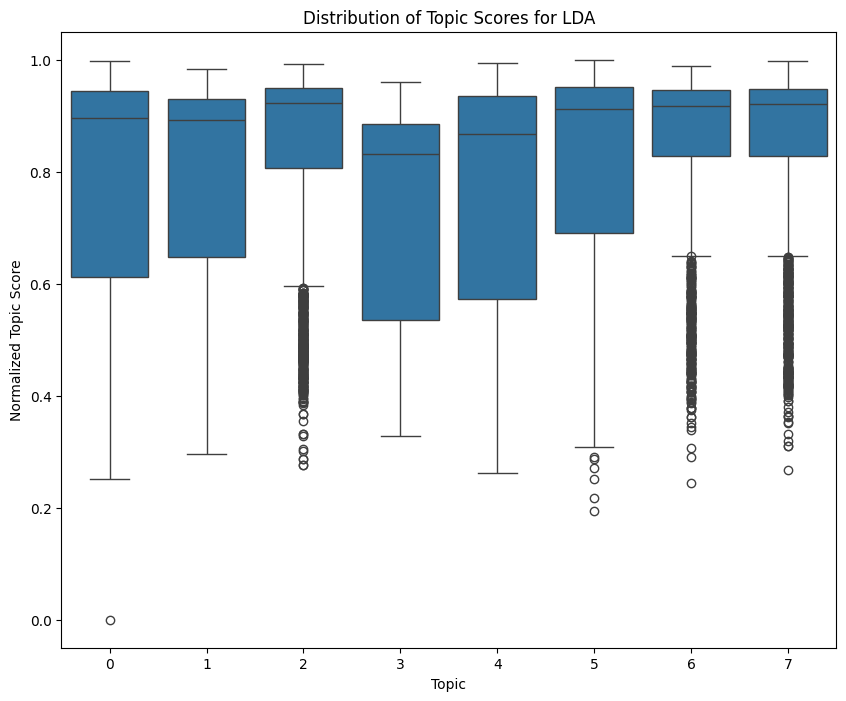

In [10]:
plot_topic_score_distribution(train, 'topic_LDA', 'topic_LDA_score', 'LDA')

In [11]:
# top 20 confidence for each topic
for topic in range(NUM_OF_TOPIC):
    print('topic: ', topic, '\n', train[train['topic_LDA']==topic].sort_values('topic_LDA_score', ascending=False)['title_japanese'].head(20).tolist())

topic:  0 
 ['デッドマン・ワンダーランド', '少女たちは荒野を目指す', '錆色のアーマ-黎明-', 'エンジェル・ハント', '家なき子', '魔法科高校の優等生', 'エスケープドロップ', 'Fate/kaleid liner プリズマ☆イリヤ ツヴァイ!', '이혼해주세요, 남편님!', 'テガミバチ 光と青の幻想夜話', 'トーマ', '食い詰め傭兵の幻想奇譚', '背すじをピン！と～鹿高競技ダンス部へようこそ～', '素晴らしい季節に優しい君と', 'ハイスクールD×D BorN', 'Days of Delight', '2.5次元の誘惑〈りりさ〉', 'ブラックキャット', 'アークIX', 'ジャンキーナイトタウンオーケストラ']
topic:  1 
 ['神話伝説の英雄の異世界譚', 'フルムーンジョーカー', '空中ブランコ', 'ギルティクラウン', '花より男子', 'トラブ ルダブルフェイス', 'MODS', '手裏剣とプリーツ', '装甲騎兵ボトムズ\u3000ビッグバトル', '俺だけ入れる隠しダンジョン ～こっそり鍛えて世界最強～', '自画像', '痴漢電車', 'ばなにゃ ふしぎななかまたち', '古墳ギャルのコフィー', '脱法テイマーの成り上がり冒険譚～Sランク美少女冒険者が俺の獣魔になっテイマす～ THE COMIC', 'PERSONA3 THE MOVIE —#3 Falling Down—', '銀塩少年', 'おはようサイコパス', '伊藤潤二自選傑作集', 'ノゾ×キミ']
topic:  2 
 ['機動戦士ガンダム 水星の魔女 PROLOGUE', '눈보리', 'こちらラスボス魔王城前「教会」', '山ねずみ ロッキーチャック', 'まことしやかに舞う花は', '모럴센스', 'ある日のCLAMP学園探偵団', 'モッシュレース', 'おおかみこどもの雨と雪', 'あのコの秘密', '黒鷺死体宅配便スピンオフ 松岡國男妖怪退治', '君へ結ぶハッピーエンド', '소녀교육헌장', '通常攻撃が全体攻撃で二回攻撃のお母さんは好きですか？', '知ってるよ。', '終わりのセラフ', '꼬리잡기', 'ドラゴンボールZ とびっきりの最強対最強', 'PSYЯEN -サイレン-', 'コンク

## NMF

In combining the title and synopsis embeddings for each anime/manga entry, we faced the challenge of differing word lengths. Directly stacking the embeddings could cause imbalance in representing the two sources of information. To address this, we chose to average the embeddings for each entry, allowing us to capture the overall semantic meaning of the entire document without losing the key contextual information. While it does lose some individual word-level granularity, the averaged vector still provides a strong representation of the dominant themes.

In [12]:
train['title_en_skipgram'][0].shape

(1, 300)

In [13]:
train['synopsis_skipgram'][0].shape

(100, 150)

In [14]:
# combine skip-gram title and synopsis together as input of topic modeling

train['combined_embedding'] = train.apply(
    lambda row: np.hstack((
        np.mean(row['title_en_skipgram'], axis=0),
        np.mean(row['synopsis_skipgram'], axis=0)
    ))
    , axis=1
)
train['combined_embedding'][0].shape

(450,)

In [15]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# convert the series into a 2D numpy array
embedding_matrix = np.vstack(train['combined_embedding'].values)

# apply Min-Max Normalization to due with negative value
min_max_scaler = MinMaxScaler()
embedding_matrix_non_negative = min_max_scaler.fit_transform(embedding_matrix)

nmf_model = NMF(n_components=NUM_OF_TOPIC, random_state=RANDOM_SEED, init="nndsvd", max_iter=20000)
nmf_topic_distribution = nmf_model.fit_transform(embedding_matrix_non_negative)

# find the dominant topic for each document
train['topic_nmf'] = np.argmax(nmf_topic_distribution, axis=1)
# the confidence score for each document
train['topic_nmf_score'] = np.max(nmf_topic_distribution, axis=1)
# normalize the confidence scores to range between 0 and 1
train['topic_nmf_score'] = (train['topic_nmf_score'] - train['topic_nmf_score'].min()) / (train['topic_nmf_score'].max() - train['topic_nmf_score'].min())

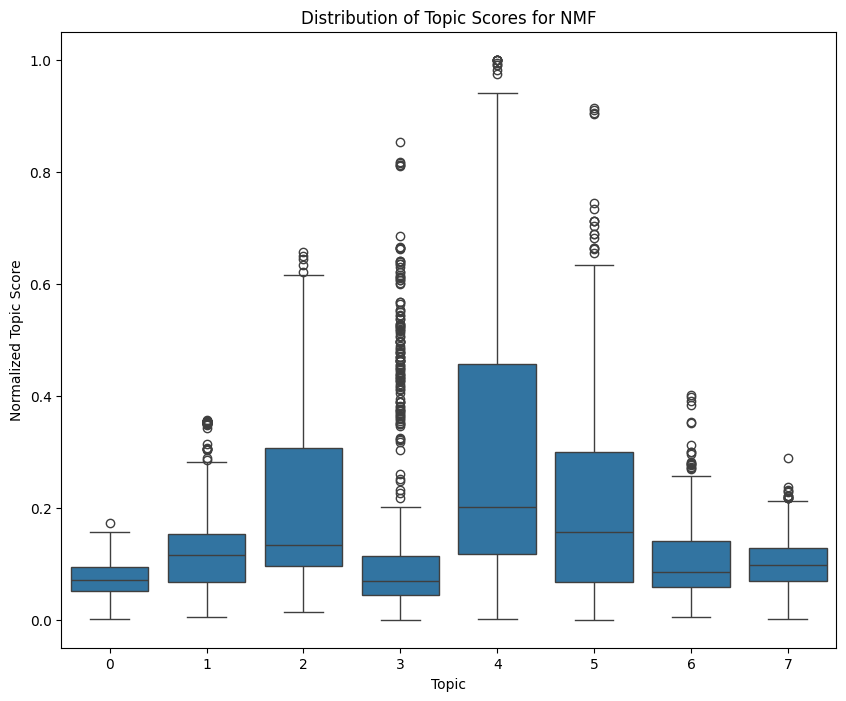

In [16]:
plot_topic_score_distribution(train, 'topic_nmf', 'topic_nmf_score', 'NMF')

In [17]:
# top 20 confidence for each topic
for topic in range(NUM_OF_TOPIC):
    print('topic: ', topic, '\n', train[train['topic_nmf']==topic].sort_values('topic_nmf_score', ascending=False)['title_japanese'].head(20).tolist())

topic:  0 
 ['菊門高校モテ部', 'かんしゃく玉のラブソング', '起きて最初にすることは', 'NightS', '冷たい太陽', '苺シンドローム', 'わらってヒミコさん', 'テラストーリー', 'いつかの恋と夏の果て', 'ヒミツのおくすり', 'ハグで終わるわけねぇだろ？～今夜、同期に抱き潰される', '人妻♪かすみさん', 'アステリスク', '簡易的パーバートロマンス', 'いつでもきみが', 'サクラ咲くころ', 'SとN', '사랑하는 소년', '鈍色の箱の中で', '宇津井くんがシてくれない']
topic:  1 
 ['僕が愛してあげる', '愛じゃたりない?', '좋아하는 만큼', 'アイはどこいった?', '愛だろ。', '愛をこめて', 'NOT/LOVE', '思い、思われ、ふり、ふられ', 'ヴァージンズ\u3000感動の純愛', 'この恋は手に余る', '君とじゃなきゃ恋もできない', '好きっていいなよ。', '恋のようなものじゃなく', 'それを恋と呼ばずになんと言う', '그들도 사랑을 한다', '「好き」だなんて絶対に言わない', '恋について', 'たぶんソレがラブなんじゃなかろうか。', '思い、思われ、ふり、ふられ', '愛']
topic:  2 
 ['捨て猫のカルテ', 'TR 逆痴漢専用車両', 'あたしたち犯された', '大人になっても', 'しあわせっくす', 'おあそびもほどほどに', 'こいねつリップス', '夢中になっちまえ！', 'ホントノ僕ラ', '桜子さん本当はこれが欲しいんだよね？', 'フロイトシュテインの双子', '塾メス♀', '君の顔が好きだ', 'カラーチャートをキミに', 'あきらめるのはまだ早い', '通り抜けできません', '妹の味は蜜の味', '欲情アクアリウム', 'セフレから彼女になったワケ', '誰かを好きな人']
topic:  3 
 ['ALL THAT GUNDAM', '劇場版\u3000機動戦士ガンダム I\u3000特別編', '機動戦士ガンダム', '機動戦士ガンダム00', '機動戦士ガンダム00', '機動戦士ガンダム 00F', '新機動戦記ガンダムＷ〈ウイング〉', '機動戦士ガンダムUC〈ユニコーン〉', '機動戦士ガン